# DP-SGD + Rényi DP (RDP) — Compact Demo

What you'll see quickly:
- Train a tiny logistic regression with DP-SGD (clipping + Gaussian noise).
- Plot training loss with vs. without DP.
- Track a toy RDP accountant over steps, convert to (ε, δ), and plot ε vs. steps.

Why it matters for CAS 751:
- DP-SGD is the de-facto approach for deep learning privacy.
- RDP gives clean composition for many steps; convert to (ε, δ) for reporting.

Notes:
- This is a didactic mini-demo, not a production accountant.
- Uses simple subsampling approximation and Gaussian RDP formula.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import log_loss

np.random.seed(42)

# Helper: sigmoid
sigmoid = lambda z: 1.0 / (1.0 + np.exp(-z))

def plot_setup():
    plt.style.use("seaborn-v0_8")
    plt.rcParams.update({"figure.figsize": (6, 4), "axes.grid": True})
plot_setup()

In [2]:
# Generate a small binary classification dataset
n_samples, n_features = 2000, 10
X, y = make_classification(
    n_samples=n_samples, n_features=n_features, n_informative=6,
    n_redundant=2, n_clusters_per_class=2, flip_y=0.01, class_sep=1.0,
    random_state=42
)
X = (X - X.mean(0)) / (X.std(0) + 1e-8)

def init_model():
    W = np.zeros(n_features)
    b = 0.0
    return W, b

W0, b0 = init_model()
W0.shape, b0

((10,), 0.0)

In [3]:
def batch_logistic_gradients(W, b, Xb, yb):
    z = Xb @ W + b
    p = sigmoid(z)
    # per-example gradients for binary cross-entropy
    # grad_W_i = (p_i - y_i) * x_i; grad_b_i = (p_i - y_i)
    residual = (p - yb)
    grad_W = residual[:, None] * Xb
    grad_b = residual
    return grad_W, grad_b


def clip_and_aggregate(grad_W, grad_b, C):
    # grad_W: [B, d], grad_b: [B]
    norms = np.sqrt((grad_W**2).sum(axis=1) + grad_b**2)
    scale = np.clip(C / (norms + 1e-12), None, 1.0)
    grad_W_clipped = grad_W * scale[:, None]
    grad_b_clipped = grad_b * scale
    return grad_W_clipped.mean(axis=0), grad_b_clipped.mean(axis=0)


def dp_sgd_train(X, y, lr=0.2, epochs=10, batch_size=128, C=1.0, noise_multiplier=1.0, dp=True):
    n, d = X.shape
    W, b = init_model()
    losses = []
    steps = 0
    rng = np.random.default_rng(123)
    for ep in range(epochs):
        perm = rng.permutation(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            Xb, yb = X[idx], y[idx]
            gW, gb = batch_logistic_gradients(W, b, Xb, yb)
            gW_agg, gb_agg = clip_and_aggregate(gW, gb, C)
            if dp:
                # Add Gaussian noise N(0, (C*sigma)^2 / B^2) to average gradient
                sigma = noise_multiplier
                gW_agg = gW_agg + (C * sigma / batch_size) * rng.normal(size=d)
                gb_agg = gb_agg + (C * sigma / batch_size) * rng.normal()
            W -= lr * gW_agg
            b -= lr * gb_agg
            steps += 1
            # Track minibatch loss (non-private report)
            p = sigmoid(Xb @ W + b)
            losses.append(log_loss(yb, p, labels=[0,1]))
    return W, b, np.array(losses), steps

Steps — non-DP: 160, DP: 160


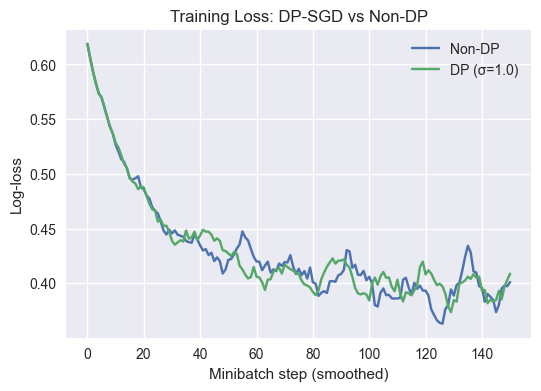

In [4]:
# Train baseline and DP models
W_ndp, b_ndp, losses_ndp, steps_ndp = dp_sgd_train(X, y, dp=False, lr=0.2, epochs=10, batch_size=128, C=1.0, noise_multiplier=0.0)
W_dp, b_dp, losses_dp, steps_dp = dp_sgd_train(X, y, dp=True, lr=0.2, epochs=10, batch_size=128, C=1.0, noise_multiplier=1.0)

print(f"Steps — non-DP: {steps_ndp}, DP: {steps_dp}")

# Smooth a bit for visibility
k = 10
sm_ndp = np.convolve(losses_ndp, np.ones(k)/k, mode='valid')
sm_dp = np.convolve(losses_dp, np.ones(k)/k, mode='valid')

plt.figure()
plt.plot(sm_ndp, label='Non-DP')
plt.plot(sm_dp, label='DP (σ=1.0)')
plt.xlabel('Minibatch step (smoothed)')
plt.ylabel('Log-loss')
plt.title('Training Loss: DP-SGD vs Non-DP')
plt.legend();
plt.show()

In [5]:
# Toy RDP accountant (didactic)
# Based on Gaussian mechanism RDP: epsilon(α) = α/(2σ^2) for full participation.
# With Poisson subsampling q, use a crude bound: epsilon(α) ≈ (q**2) * α / (2 σ^2).
# Then convert to (ε, δ): ε(δ) = min_{α>1} [ epsilon(α) + log(1/δ)/(α-1) ].

import math

def rdp_gaussian(alpha, sigma, q):
    return (q**2) * alpha / (2.0 * sigma**2)


def rdp_to_dp(eps_rdp_total_fn, deltas=(1e-5,), max_alpha=256):
    # Search over integer alphas >= 2
    results = {}
    for delta in deltas:
        best = float('inf')
        best_alpha = None
        for alpha in range(2, max_alpha+1):
            eps_rdp = eps_rdp_total_fn(alpha)
            eps = eps_rdp + math.log(1.0/delta) / (alpha - 1)
            if eps < best:
                best, best_alpha = eps, alpha
        results[delta] = (best, best_alpha)
    return results

# Training parameters governing privacy
epochs = 10
batch_size = 128
n = n_samples
steps = math.ceil(n / batch_size) * epochs
q = batch_size / n
sigma = 1.0  # noise multiplier used above

# Total RDP across steps: sums over steps
rdp_total = lambda alpha: steps * rdp_gaussian(alpha, sigma=sigma, q=q)

# Convert to (ε, δ)
deltas = (1e-5, 1e-6, 1e-7)
results = rdp_to_dp(rdp_total, deltas=deltas, max_alpha=256)
for dlt, (eps, a) in results.items():
    print(f"delta={dlt:.0e}: epsilon≈{eps:.3f} at alpha={a}")

delta=1e-05: epsilon≈4.213 at alpha=7
delta=1e-06: epsilon≈4.595 at alpha=8
delta=1e-07: epsilon≈4.924 at alpha=8


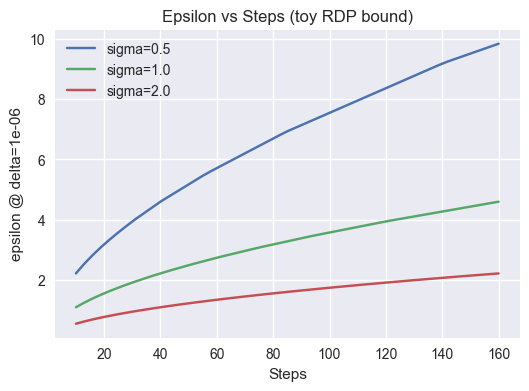

In [6]:
# Plot epsilon vs steps for a fixed delta
fixed_delta = 1e-6
sigmas = [0.5, 1.0, 2.0]

plt.figure()
for sigma in sigmas:
    epsilons = []
    step_grid = np.arange(10, steps+1, max(1, steps//50))
    q = batch_size / n
    for s in step_grid:
        rdp_total = lambda alpha, s=s, sigma=sigma: s * rdp_gaussian(alpha, sigma=sigma, q=q)
        res = rdp_to_dp(lambda a, r=rdp_total: r(a), deltas=(fixed_delta,), max_alpha=256)
        epsilons.append(res[fixed_delta][0])
    plt.plot(step_grid, epsilons, label=f"sigma={sigma}")
plt.xlabel('Steps')
plt.ylabel(f'epsilon @ delta={fixed_delta:.0e}')
plt.title('Epsilon vs Steps (toy RDP bound)')
plt.legend();
plt.show()